In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import pickle

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.analyze_bogota import summary_stats, filter_and_home_assign

np.random.seed(42)
pd.set_option('display.max_columns', 999)

# Loading data

(If you have access to the pickled data files, begin running cells at the cell that reads `### PICKLE FILE ###`)

In [10]:
# Loading 2013 tweets
bo13 = pd.read_csv('../data/tweets/bo_2013.csv')

In [11]:
# Loading shapefiles
bo_shapefiles = convert_shapefile_crs(
    gpd.read_file('../data/shapefiles/MGN_Seccion_urbana/MGN_Seccion_urbana.shp')
)

# Filtering data and adding tracts

First, we want to filter the data to exclude rare Twitter users (tweet count below median number of tweets/user) and power users (tweet count above 99th percentile of tweets/user). Methodology is as follows:

1. Compute 50th and 99th percentile of tweets/user
1. Select the subset of tweets made by users falling between those bounds
1. Geometrize tweet data by using lat/lon
1. Compute a spatial join between tweets and the tract shapefiles
1. Add datetime information for home location analysis
1. Assign home locations (`home` column) and whether or not tweet is made from home (`is_home` column)

In [12]:
# Original dataset analysis
pct_50, pct_99 = summary_stats(bo13)

7763433 total tweets
184020 unique users

Median number of tweets/user: 5.0 tweets
99th percentile of tweets/user: 615.0 tweets


In [5]:
bo13 = filter_and_home_assign(bo13, bo_shapefiles, pct_50, pct_99)

In [13]:
### PICKLE FILE ###
# protocol=4 for large data files (https://stackoverflow.com/a/56151766)
# with open('../data/bo13.pkl', 'wb') as file:
#     pickle.dump(bo13, file, protocol=4)

with open('../data/bo13.pkl', 'rb') as file:
    bo13 = pickle.load(file)

# Analysis

Before we begin our analysis, it helps to show a visual analysis of where our tweets are located. In the map below, we differentiate between the tweets that are assigned a tract (`SECU_CCNCT`) in our spatial join:

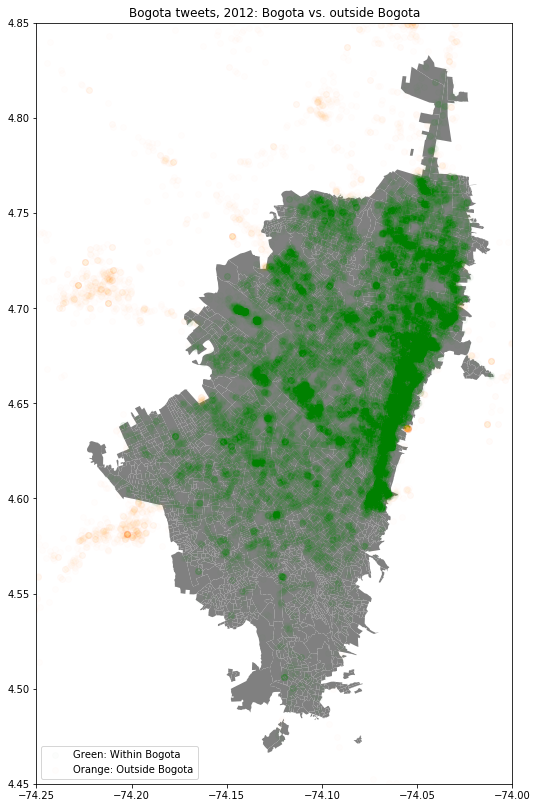

In [4]:
### Plot a 1% sample of 2013 tweets ###
# Green tweets: Joined to a SECU_CCNCT
# Orange tweets: No SECU_CCNCT assigned (NaN)
# Gray: Bogota shapefile

fig, ax = plt.subplots(figsize=(20, 14))
bo_shapefiles['geometry'].plot(ax=ax, color='gray')
sample = bo13.sample(frac=0.01, random_state=42)
sample[~sample['SECU_CCNCT'].isnull()].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Within Bogota')
sample[sample['SECU_CCNCT'].isnull()].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='Orange: Outside Bogota')
plt.legend()
plt.axis([-74.25, -74, 4.45, 4.85])
plt.title('Bogota tweets, 2013: Bogota vs. outside Bogota');

From this, we see that we can use `[~bo13['SECU_CCNCT'].isnull()]` as a filter to select just the tweets in Bogota, which is our area of interest. For all following analyses, we will restrict the population to just the tweets that fall inside Bogota depicted by the shapefile.

Our first summary statistic computes the ratio of tweets that have a home assignment.

In [14]:
num_home_assigned_tweets = (~bo13.loc[~bo13['SECU_CCNCT'].isnull(), 'home'].isnull()).sum()
n_tweets = len(bo13[~bo13['SECU_CCNCT'].isnull()])

print("{}/{} = {:.2%} of tweets have a home assignment.".format(
    num_home_assigned_tweets, n_tweets, num_home_assigned_tweets / n_tweets
))

2979173/4467188 = 66.69% of tweets have a home assignment.


Next, we are interested in the ratio of users that have a home assignment.

In [15]:
num_users_with_home = (~bo13.loc[~bo13['SECU_CCNCT'].isnull()].groupby('u_id')['home'].first().isnull()).sum()
n_users = len(bo13[~bo13['SECU_CCNCT'].isnull()].groupby('u_id'))

print("{}/{} = {:.2%} of users have a home assignment.".format(
    num_users_with_home, n_users, num_users_with_home / n_users
))

19918/88915 = 22.40% of users have a home assignment.


Lastly, we want to know the ratio of tweets that were made from home (i.e. `SECU_CCNCT` and `home` are equal).

In [16]:
num_tweets_from_home = bo13.loc[~bo13['SECU_CCNCT'].isnull(), 'is_home'].sum()

print("{}/{} = {:.2%} of tweets are posted from the home tract.".format(
    num_tweets_from_home, n_tweets, num_tweets_from_home / n_tweets
))

1727166/4467188 = 38.66% of tweets are posted from the home tract.


Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Buenos Aires with respect to residence/nonresidence?

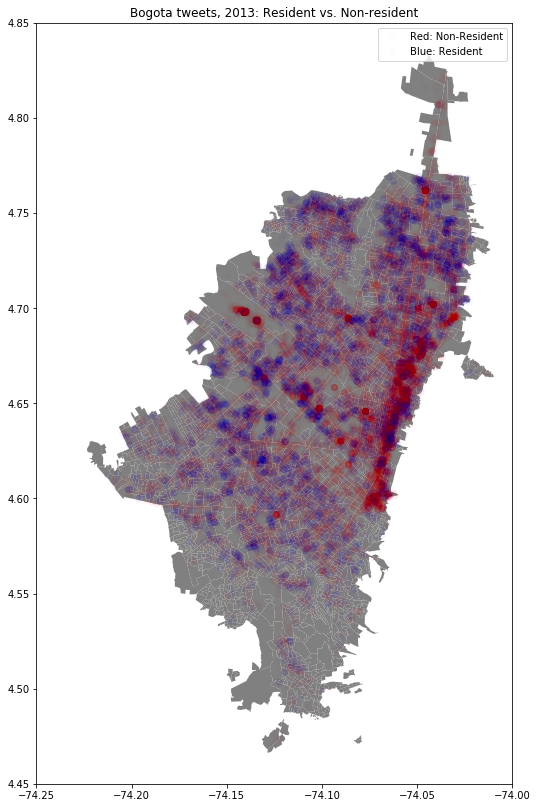

In [17]:
### Plot a 1% sample of 2013 tweets ###
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray: Bogota shapefile

fig, ax = plt.subplots(figsize=(20, 14))
bo_shapefiles['geometry'].plot(ax=ax, color='gray')
sample = bo13[~bo13['SECU_CCNCT'].isnull()].sample(frac=0.01, random_state=42)
sample[~sample['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
sample[sample['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-74.25, -74, 4.45, 4.85])
plt.title('Bogota tweets, 2013: Resident vs. Non-resident');

# Saving output

For future reference, we save an output CSV of all the tweets, spatially joined to the Bogota shapefiles. There are two additional columns:

- `home`: NaN (missing value) if the tweet user has no home location, else the home tract ('SECU_CCNCT')
- `is_home`: an indicator (True/False) determining whether `home == SECU_CCNCT`

In [19]:
bo13.to_csv('../data/bo13_joined.csv.gz', index=False, compression='gzip')